# Android Robust Malware Detection Challenge

In this online challenge, we focus on detecting malware for the Android Operating System. 
On this task, machine learning usually performs well, learning common patterns from data and enabling the detection of potentially never-before-seen malware samples. 

However, it has been shown that those detectors (i) tend to exhibit a rapid performance decay over time due to the natural evolution of samples and (ii) can be bypassed by slightly manipulating malware samples in an adversarial manner. 
The practical impact of these two issues is that current learning-based malware detectors need constant updates and retraining on newly collected and labeled data.

In this notebook, we are going to explore two important aspects of this challenge.

1. Data loading and creation of a baseline DREBIN model. Time-aware dataset splitting and understanding the statistics of the dataset.
2. Adversarial manipulations in the feature space. Determining how many features need to be changed to bypass the detector.


## Preparation

Before running the notebook, you need to complete the following steps.

1. Download the repository at: https://github.com/maurapintor/android_tutorial
2. Register to the ELSA benchmark platform: https://benchmarks.elsa-ai.eu/?ch=6&com=introduction
3. Go to Download and download these two items:
   1. APK hashes, timestamps, and labels
   2. DREBIN features
4. Put the files, unzipped in the "data" folder
5. (optional but recommended) Create a python environment `conda create -n android`
6. (optional but recommended) Activate the environment `conda activate android`
7. Install the requirements `pip install -r requirements.txt`

If you already opened and started the jupyter server, you will have to restart it for ensuring the kernel is updated with the packages.

## Preparing the data

For the first part of the tutorial, we are going to explore the files in the training folder, and then learn how to load them properly.

Let's first open the folder "data/training_set_features" and open a JSON file. **WARNING: Do not open links appearing in the repository!**

We use as a case study the popular Drebin malware detector from [Arp, Daniel, et al. "Drebin: Effective and explainable detection of android malware in your pocket." NDSS 2014](https://www.ndss-symposium.org/wp-content/uploads/2017/09/11_3_1.pdf), consisting of a linear Support Vector Machine (SVM) model trained on statically extracted binary features. 

The features are divided into 8 subsets: 

* $S_1$: hardware components requested by the application;
* $S_2$: requested permissions;
* $S_3$: app components, i.e., activities, services, content providers, and broadcast receivers;
* $S_4$: filtered intents;
* $S_5$: restricted API calls;
* $S_6$: used permissions, i.e., the permissions that are requested to execute restricted API calls from $S_5$;
* $S_7$: suspicious API calls;
* $S_8$: network addresses.

$S_1$, $S_2$, $S_3$ and $S_4$ are extracted from the `AndroidManifest.xml`, while $S_5$, $S_6$, $S_7$ and $S_8$ are extracted from the `classes.dex` files. 

Below is one example of features extracted from one sample of the dataset we are using (sha256=0A0ABCC4AAF818A3B8835C3CB2FE05E9FDB9324C564E86B365B94D4C651A05E7):

```JSON
{
    "req_permissions": [
        "android.permission.VIBRATE",
        "android.permission.GET_ACCOUNTS",
        "android.permission.SET_WALLPAPER",
        "android.permission.WRITE_EXTERNAL_STORAGE",
        "com.google.android.c2dm.permission.RECEIVE",
        "android.permission.ACCESS_NETWORK_STATE",
        "android.permission.WAKE_LOCK",
        "android.permission.INTERNET",
        "musicasetenta.radiossetenta.gratis.permission.C2D_MESSAGE"
    ],
    "activities": [
        "com.hutchind.cordova.plugins.streamingmedia.SimpleAudioStream",
        "musicasetenta.radiossetenta.gratis.MainActivity",
        "com.hutchind.cordova.plugins.streamingmedia.SimpleVideoStream",
        "com.plugin.gcm.PushHandlerActivity",
        "com.google.android.gms.ads.AdActivity"
    ],
    "services": [
        "com.plugin.gcm.GCMIntentService"
    ],
    "providers": [
        "nl.xservices.plugins.FileProvider"
    ],
    "receivers": [
        "com.plugin.gcm.CordovaGCMBroadcastReceiver"
    ],
    "features": [],
    "intent_filters": [
        "com.google.android.c2dm.intent.REGISTRATION",
        "com.google.android.c2dm.intent.RECEIVE",
        "android.intent.action.MAIN"
    ],
    "used_permissions": [
        "android.permission.GET_ACCOUNTS",
        "android.permission.SET_WALLPAPER",
        "android.permission.ACCESS_NETWORK_STATE",
        "android.permission.WAKE_LOCK",
        "android.permission.READ_EXTERNAL_STORAGE",
        "android.permission.ACCESS_FINE_LOCATION"
    ],
    "api_calls": [
        "android/content/Context;->getObbDir",
        "android/webkit/WebSettings;->setGeolocationEnabled",
        "android/accounts/AccountManager;->getAccounts",
        "android/net/ConnectivityManager;->getNetworkInfo",
        "android/net/ConnectivityManager;->getActiveNetworkInfo",
        "android/app/WallpaperManager;->setBitmap",
        "android/app/WallpaperManager;->setStream",
        "android/content/Context;->getExternalCacheDir",
        "android/net/ConnectivityManager;->isActiveNetworkMetered",
        "android/os/Environment;->getExternalStorageDirectory",
        "android/os/PowerManager;->newWakeLock",
        "android/content/Context;->getExternalFilesDir"
    ],
    "suspicious_calls": [
        "getDeviceId",
        "getPackageInfo",
        "getExternalStorageDirectory",
        "Cipher",
        "Base64",
        "getSystemService",
        "Ldalvik/system/DexClassLoader;",
        "Ljava/io/IOException;->printStackTrace"
    ],
    "urls": [
        "http://media.admob.com/mraid/v1/mraid_app_expanded_banner.js",
        "http://schemas.android.com/apk/lib/com.google.android.gms.plus",
        "https://www.googleapis.com/auth/drive.appdata",
        "http://googleads.g.doubleclick.net/mads/static/mad/sdk/native/sdk-core-v40.html",
        "http://media.admob.com/mraid/v1/mraid_app_interstitial.js",
        "http://www.google.com",
        "https://api.whatsapp.com/send?phone",
        "https://www.googleapis.com/auth/drive.file",
        "http://media.admob.com/mraid/v1/mraid_app_banner.js",
        "http://goo.gl/naFqQk",
        "https://www.googleapis.com/auth/drive",
        "https://www.googleapis.com/auth/plus.me",
        "https://www.googleapis.com/auth/appstate",
        "http://www.google-analytics.com/collect",
        "https://www.googletagmanager.com",
        "https://ssl.google-analytics.com/collect",
        "https://www.googleapis.com/auth/drive.apps",
        "http://plus.google.com/",
        "http://googleads.g.doubleclick.net/mads/static/sdk/native/sdk-core-v40.html",
        "https://www.googleapis.com/auth/plus.login",
        "https://www.googleapis.com/auth/games.firstparty",
        "https://ssl.gstatic.com/accessibility/javascript/android/",
        "https://www.googleapis.com/auth/games"
    ]
}
```

The feature extractor uses a vectorizer to represent the data through numerical vectors.

The vectorizer $V$ is a function that creates a set of features taken from $S_1, ..., S_8$, given a dataset.
For a given dataset $D$, $V(D)$ represents the set of features extracted by the vectorizer.

The feature set comprises all the $d$ extracted features from the training data, and input samples are represented with a $d$-dimensional vector where each index position corresponds to a particular feature, and its value is $1$ if the feature is present or $0$ otherwise.
Importantly, **different datasets might produce different sets of features**, thus creating vectors that are different in their elements.

The labels are collected in the "data/training_set.csv" file. Open this CSV and observe the columns.

* sha256: this is a unique identifier of the samples. 
* timestamp: temporally localizes the sample, this is important for time-aware splitting
* label: the label is 0 if the sample is goodware, 1 if it's a malware

Try to find the apk file from before "0A0ABCC4AAF818A3B8835C3CB2FE05E9FDB9324C564E86B365B94D4C651A05E7".

```csv
0a0abcc4aaf818a3b8835c3cb2fe05e9fdb9324c564e86b365b94d4c651a05e7,2018-08-12 08:57:52,0
```


Now, let's load the dataset and inspect the features in Python.
First, we load the entire dataset, and we inspect how many goodware and malware samples we have.
We also load the timestamps, as we can separate the training and testing data more realistically in this way (following [Pendlebury, Feargus, et al. "TESSERACT: Eliminating experimental bias in malware classification across space and time." 28th USENIX security symposium (USENIX Security 19). 2019](https://www.usenix.org/conference/usenixsecurity19/presentation/pendlebury).)

In [1]:
from datetime import datetime
import pathlib
from models.drebin.features import load_features, load_labels

data_path = pathlib.Path("data")


features = list(load_features(data_path / "training_set_features"))
labels, timestamps = load_labels(
    data_path / "training_set_features",
    data_path / "training_set.csv",
    return_timestamp=True,
)

# how many samples are goodware? How many are malware?
print(f"Total samples: {len(labels)}")
print(f"Number of goodware samples: {(labels==0).sum()}")
print(f"Number of malware samples: {(labels==1).sum()}")

# time aware splitting
threshold = datetime(year=2019, month=1, day=1)
train_index = [i for i, t in enumerate(timestamps) if t < threshold]
test_index = [i for i, t in enumerate(timestamps) if t >= threshold]
x_train, y_train = [features[i] for i in train_index], labels[train_index]
x_test, y_test = [features[i] for i in test_index], labels[test_index]

print(f"Split training set: {len(x_train)}")
print(f"Split testing set: {len(x_test)}")


Total samples: 75000
Number of goodware samples: 67500
Number of malware samples: 7500
Split training set: 50000
Split testing set: 25000


## Train and evaluate a classifier

Then, we can finally create our classifier. We are going to use a predefined class implementing the DREBIN vectorizer and classifier.


In [2]:
from models.drebin.drebin import DREBIN

classifier = DREBIN(C=0.1)
# train the classifier on the training set
classifier.fit(x_train, y_train)

To test the performance of our new classifier, we have to remember that we cannot use accuracy, as the dataset is unbalanced (number of goodware files >>> number of malware files).
For this reason, we use the following metrics:
* precision = TP / (TP + FP)
* TPR (recall) = TP / (TP + FN)
* FPR = FP / (FP + TN)
* F1-score = 2 (P * R)/(P + R)
Additionally, we are going to use a ROC curve, showing the FPR vs TPR at increasing values of the decision threshold.

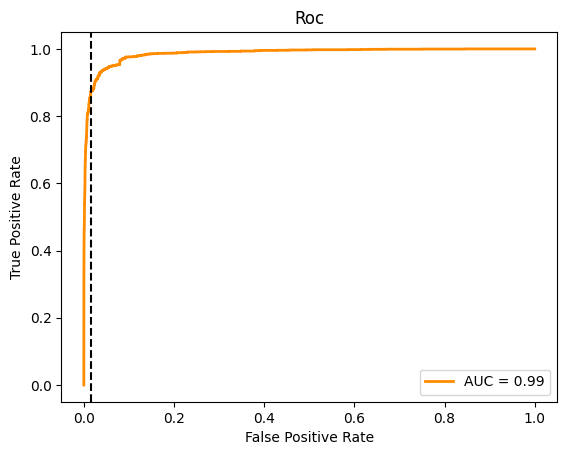

------------------------------
F1 Score: 0.8667
Precision: 0.8587
TPR: 0.8748
FPR: 0.0160
------------------------------


<Figure size 640x480 with 0 Axes>

In [3]:
from models.performance import get_metrics, plot_roc

# evaluate the classifier on the testing set
preds, scores = classifier.predict(x_test)
plot_roc(y_true=y_test, scores=scores, title="Roc")
get_metrics(y_true=y_test, y_pred=preds)

Finally, we can save the classifier to load it later. In this case, we have to provide a path for the vectorizer and a path for the classifier weights.

In [4]:
# save the classifier
output_path = pathlib.Path("outputs")
output_path.mkdir(exist_ok=True)
vect_path = output_path / "vectorizer.npz"
classifier_path = output_path / "classifier.npz"
classifier.save(vect_path, classifier_path)

# to load the classifier:
# classifier = classifier.load(vectorizer_path=vect_path, classifier_path=classifier_path)


## Adversarial manipulations in the feature space

Now that we have a classifier, we can manipulate some malware samples to bypass it.
We can to this with a **black-box attack** (already implmented), that creates candidate feature modifications and applies them to the feature set.
However, we encourage to have a look at its code to understand its main components.

- The attack process consists of adding (or removing) a fixed-length set of features (contained in a manipulation vector), selected by a **Genetic Algorithm** that optimizes it based on the detector's output score. The features to be injected are sampled from a validation set composed of legitimate samples (`goodware_features`), while the features to be removed are the ones of the sample under attack (`malware_features`).
- Note that not all features can be removed. We only consider those manipulations that **can be applied to APKs without breaking or altering their functionality**. In this way, we try to simulate a realistic attacker that is able to directly manipulate the APK file. While it is safe to inject features (e.g., by adding code slices that are never invoked), removing them (e.g., with obfuscation or encryption techniques) is not always possible. For this reason, the attack cannot remove features from $S_1$, $S_2$, $S_4$, and $S_6$ subsets.
- The attack has no knowledge about the classifier architecture and parameters and can access its output score only. However, we assume the attacker is aware of and can directly manipulate the feature representation used by the detector. In a real-world scenario, this still represents a strong attacker as usually the feature extraction process is obscure and the attacker does not know which features are actually extracted and fed into the classifier.

These are the main components of the attack:
- During the initialization phase, the attack randomly chooses sets of sparse manipulation vectors (`n_candidates` controls the number of sets, whereas `n_features` controls how many features are modified at once). 
- Then, it iteratively combines and mutates them, until an evading sample is found or the maximum number of iterations is reached (`n_iterations`).




In [5]:
from adv.feature_space_attack import FeatureSpaceAttack

# evaluate the classifier on the testing set
preds, scores = classifier.predict(x_test)

# separate goodware and malware
goodware = [x_test[i] for (i, label) in enumerate(y_test) if label == 0][:100]
malware = [x_test[i] for (i, label) in enumerate(y_test) if label == 1][:10]

# perform attack
attack = FeatureSpaceAttack(classifier, logging_level=10)
adv_features = attack.run(
    malware_features=malware,
    goodware_features=goodware,
    n_iterations=200,
    n_features=10,
    n_candidates=5,
    stagnation=5,
    seed=0,
)

# predict malware before manipulation
preds, scores = classifier.predict(malware)
true_positives = (preds == 1).mean()
print("TPR before manipulation", true_positives)

# predict malware after manipulation
preds, scores = classifier.predict(adv_features)
true_positives = (preds == 1).mean()
print("TPR after manipulation", true_positives)


2024/08/27 19:32:27 feature_space_attack.py[line:276] DEBUG: Generating candidates
2024/08/27 19:32:27 feature_space_attack.py[line:114] INFO: Attacking sample 0
2024/08/27 19:32:27 feature_space_attack.py[line:122] DEBUG: Skipping sample, it is not detected as malware
2024/08/27 19:32:27 feature_space_attack.py[line:114] INFO: Attacking sample 1
2024/08/27 19:32:27 feature_space_attack.py[line:124] DEBUG: Initial confidence: 0.22646650755302275
2024/08/27 19:32:28 feature_space_attack.py[line:218] DEBUG: Building manipulation space
2024/08/27 19:32:28 feature_space_attack.py[line:193] DEBUG: Generation 1 - score -0.672854735367382
2024/08/27 19:32:28 feature_space_attack.py[line:114] INFO: Attacking sample 2
2024/08/27 19:32:28 feature_space_attack.py[line:124] DEBUG: Initial confidence: 0.32585058721036525
2024/08/27 19:32:30 feature_space_attack.py[line:218] DEBUG: Building manipulation space
2024/08/27 19:32:30 feature_space_attack.py[line:193] DEBUG: Generation 1 - score -0.087488

TPR before manipulation 0.9
TPR after manipulation 0.4


Let's now print the features that are changed by the attack (for simplicity we do this only with one sample of the ones selected).

In [6]:
def print_modified_features(sample, adv_sample):
    
    features = dict()
    adv_features = dict()
    for f in sample + adv_sample:
        prefix = f.split(":")[0]
        features[prefix] = []
        adv_features[prefix] = []
    
    for f in sample:
        prefix = f.split(":")[0]
        suffix = f[len(prefix)+2:]
        if prefix == "urls":
            suffix = suffix.replace(".", "[dot]")
        features[prefix].append(suffix)
    for f in adv_sample:
        prefix = f.split(":")[0]
        suffix = f[len(prefix)+2:]
        if prefix == "urls":
            suffix = suffix.replace(".", "[dot]")
        adv_features[prefix].append(suffix)
    
    print("Printing modified features:")
    for f in features:
        features_sample = set(features[f])
        features_adv_sample = set(adv_features[f])
        changed_features = features_adv_sample.difference(features_sample)
        removed_features = features_sample.difference(features_adv_sample)
        if len(changed_features) > 0:
            print(f)
            print("Added features: ", list(changed_features))
            print("Removed features: ", list(removed_features))
        
index = 3
print_modified_features(malware[index], adv_features[index])

Printing modified features:
req_permissions
Added features:  ['android.permission.BLUETOOTH']
Removed features:  []
intent_filters
Added features:  ['android.intent.action.SEND']
Removed features:  []
api_calls
Added features:  ['android/os/Environment;->getExternalStorageDirectory']
Removed features:  []
urls
Added features:  ['https://www[dot]googleapis[dot]com/auth/fitness[dot]nutrition[dot]read', 'https://www[dot]facebook[dot]com/audience_network/server_side_reward', 'https://translate[dot]yandex[dot]net/api/v1[dot]5/tr[dot]json/translate?key', 'https://mobilecrashreporting[dot]googleapis[dot]com/v1/crashes']
Removed features:  []
